In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm


In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick

# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

# model path
val_rmse_str = "0.2542"   # same rmse in the filename

path_csv_load = save_path / f"{ticker}_final.csv"
path_csv_save = save_path / f"{ticker}_test_DF.csv"

model_path = save_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2542.pth')

In [3]:
df = pd.read_csv(path_csv_load, index_col=0, parse_dates=True)
df

open        high         low       close  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700   

                        volume       r_1       r_5      r_15    vol_15  \
2014-04-03 12:06:00     4580.0 -0.000180 -0.000180 -0.000180  0.000046   
2014-04-03 12:07:00     4540.0 -0.000180 -0.000360 -0.000360  0.000063   
2014-04-03 12:08:00     4500.0 -0.000180 -0.000540 -0.000540  0.000075   
2014-04-03 12:09:00     4460.0 -0.000180 -0.000720 -0.000720  0.000082   
2014-04-03 12:10:00     4420.0 -0.000180 -0.000900 -0.000900  0.000088   
...                        ...       ...       ...       ...       ...   
2025-06-18 20:56:00   621199.0  0.001124 -0.004226 -0.009661  0.001493   
2025-06-18 20:57:00   624198.0 -0.001066 -0.005063 -0.010671  0.001487   
2025-06-18 20:58:00   454542.0 -0.000404 -0.005811 -0.011816  0.001436   
2025-06-18 20:59:00  1094746.0 -0.000173 -0.004434 -0.011932  0.001432   
2025-06-18 21:00:00  7649838.0  0.001901  0.001382 -0.009290  0.001592   

                     volume_spike  vwap_dev     rsi_14         bid  \
2014-04-03 12:06:00      0.568641 -0.000178   0.000000   28.636251   
2014-04-03 12:07:00      0.570338 -0.000355   0.000000   28.631098   
2014-04-03 12:08:00      0.574408 -0.000531   0.000000   28.625944   
2014-04-03 12:09:00      0.581017 -0.000705   0.000000   28.620791   
2014-04-03 12:10:00      0.590413 -0.000878   0.000000   28.615637   
...                           ...       ...        ...         ...   
2025-06-18 20:56:00      2.462713  1.257638  17.019768  173.512900   
2025-06-18 20:57:00      2.154838  1.255215  11.648165  173.328000   
2025-06-18 20:58:00      1.439161  1.254293  11.384870  173.258000   
2025-06-18 20:59:00      2.836382  1.253874  11.830567  173.228000   
2025-06-18 21:00:00      8.568493  1.257962  22.962317  173.557600   

                            ask  signal_smooth  
2014-04-03 12:06:00   28.653438       0.348124  
2014-04-03 12:07:00   28.648282       0.350528  
2014-04-03 12:08:00   28.643125       0.352926  
2014-04-03 12:09:00   28.637968       0.355320  
2014-04-03 12:10:00   28.632811       0.357710  
...                         ...            ...  
2025-06-18 20:56:00  173.617100       0.002995  
2025-06-18 20:57:00  173.432000       0.002906  
2025-06-18 20:58:00  173.362000       0.005611  
2025-06-18 20:59:00  173.332000       0.006685  
2025-06-18 21:00:00  173.661800       0.003506  

[1856408 rows x 15 columns]

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

model_best


{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 0.7,
 'DROPOUT_LONG': 0.4,
 'DROPOUT_SHORT': 0.3,
 'EARLY_STOP_PATIENCE': 20,
 'ETA_MIN': 1e-05,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 64,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 4,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 32,
 'TRAIN_BATCH': 16,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.001}


DualMemoryLSTM(
  (short_lstm): LSTM(12, 32, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(32, 64, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:

print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=881299, val=228190, te=239319
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51603
Test zero‐forecast baseline RMSE = 0.55215


std val: 0.32934162
std test: 0.3403753


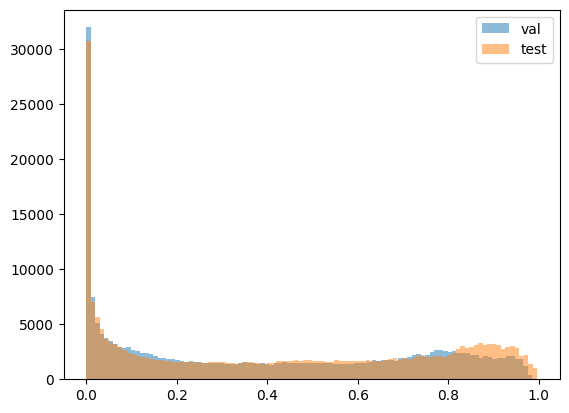

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test"
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats
            total_sq_error += (pred - y).pow(2).sum().item()
            total_windows  += y.numel()

            all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    rmse = math.sqrt(total_sq_error / total_windows)
    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [9]:
val_rmse, val_preds     = evaluate_model(model_best, val_loader, device, split_name="Validation")
test_rmse, test_preds   = evaluate_model(model_best, test_loader, device, split_name="Test")

test_preds.shape

Validation:   0%|          | 0/414 [00:00<?, ?day/s]


Validation RMSE over 228190 windows = 0.25372


Test:   0%|          | 0/422 [00:00<?, ?day/s]


Test RMSE over 239319 windows = 0.31639


(239319,)

In [10]:

def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    look_back: int,
    day_id_te: np.ndarray,
    pred_threshold: float,
    trailing_stop_thresh: float,
    regular_start_shifted: datetime.time,
    path_csv_save: str
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_out.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_out.index.normalize().isin(test_days)
        & (df_out.index.time >= regular_start_shifted) 
    )
    cand = df_out.loc[mask]

    # 4) Within each test day, drop the initial look_back rows
    valid_idx = (
        cand
        .groupby(cand.index.normalize(), sort=False)
        .apply(lambda g: g.index[look_back:])
        .explode()
    )
    valid_idx = pd.DatetimeIndex(valid_idx.values)

    # 5) Stamp your model’s predictions on those valid slots
    if len(valid_idx) != len(preds):
        raise ValueError(
            f"Expected {len(valid_idx)} prediction slots, got {len(preds)} preds"
        )
    df_out.loc[valid_idx, "pred_signal"] = preds

    # 6) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_out[df_out.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_thresh,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_out.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 7) (Optional) persist for inspection
    df_out.to_csv(path_csv_save)

    return df_out


In [11]:
df_with_preds = add_pred_actions(
    df, test_preds, look_back,
    day_id_te, pred_threshold,
    trailing_stop_thresh, regular_start_shifted,
    path_csv_save
)

df_with_preds

open        high         low       close  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700   

                        volume       r_1       r_5      r_15    vol_15  \
2014-04-03 12:06:00     4580.0 -0.000180 -0.000180 -0.000180  0.000046   
2014-04-03 12:07:00     4540.0 -0.000180 -0.000360 -0.000360  0.000063   
2014-04-03 12:08:00     4500.0 -0.000180 -0.000540 -0.000540  0.000075   
2014-04-03 12:09:00     4460.0 -0.000180 -0.000720 -0.000720  0.000082   
2014-04-03 12:10:00     4420.0 -0.000180 -0.000900 -0.000900  0.000088   
...                        ...       ...       ...       ...       ...   
2025-06-18 20:56:00   621199.0  0.001124 -0.004226 -0.009661  0.001493   
2025-06-18 20:57:00   624198.0 -0.001066 -0.005063 -0.010671  0.001487   
2025-06-18 20:58:00   454542.0 -0.000404 -0.005811 -0.011816  0.001436   
2025-06-18 20:59:00  1094746.0 -0.000173 -0.004434 -0.011932  0.001432   
2025-06-18 21:00:00  7649838.0  0.001901  0.001382 -0.009290  0.001592   

                     volume_spike  vwap_dev     rsi_14         bid  \
2014-04-03 12:06:00      0.568641 -0.000178   0.000000   28.636251   
2014-04-03 12:07:00      0.570338 -0.000355   0.000000   28.631098   
2014-04-03 12:08:00      0.574408 -0.000531   0.000000   28.625944   
2014-04-03 12:09:00      0.581017 -0.000705   0.000000   28.620791   
2014-04-03 12:10:00      0.590413 -0.000878   0.000000   28.615637   
...                           ...       ...        ...         ...   
2025-06-18 20:56:00      2.462713  1.257638  17.019768  173.512900   
2025-06-18 20:57:00      2.154838  1.255215  11.648165  173.328000   
2025-06-18 20:58:00      1.439161  1.254293  11.384870  173.258000   
2025-06-18 20:59:00      2.836382  1.253874  11.830567  173.228000   
2025-06-18 21:00:00      8.568493  1.257962  22.962317  173.557600   

                            ask  signal_smooth  pred_signal  pred_action  
2014-04-03 12:06:00   28.653438       0.348124          NaN            0  
2014-04-03 12:07:00   28.648282       0.350528          NaN            0  
2014-04-03 12:08:00   28.643125       0.352926          NaN            0  
2014-04-03 12:09:00   28.637968       0.355320          NaN            0  
2014-04-03 12:10:00   28.632811       0.357710          NaN            0  
...                         ...            ...          ...          ...  
2025-06-18 20:56:00  173.617100       0.002995     0.405104            0  
2025-06-18 20:57:00  173.432000       0.002906     0.427654            0  
2025-06-18 20:58:00  173.362000       0.005611     0.436170            0  
2025-06-18 20:59:00  173.332000       0.006685     0.451828            0  
2025-06-18 21:00:00  173.661800       0.003506     0.453815           -1  

[1856408 rows x 17 columns]

In [12]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # full DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2025-04:


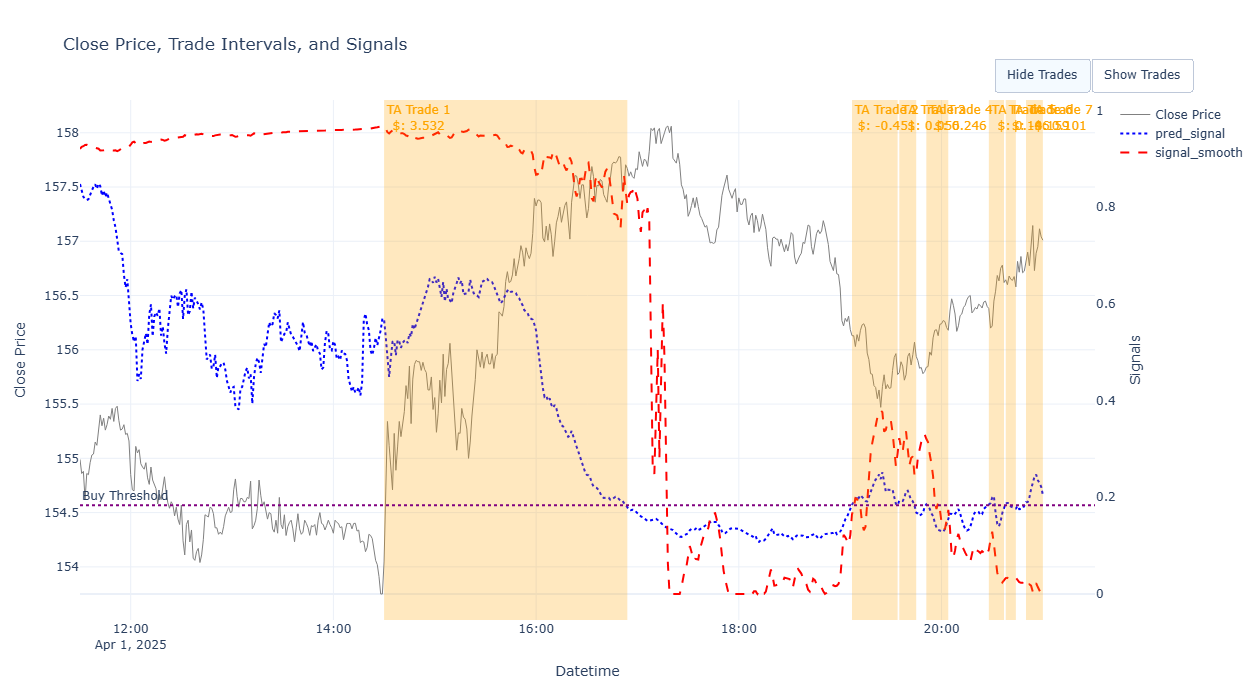


=== Performance for 2025-04-01 00:00:00 ===
Strategy Return ($): 3.501
Buy & Hold Return ($): 2.902
Trades Returns ($): [3.532, -0.451, 0.056, 0.246, 0.146, -0.159, 0.101]


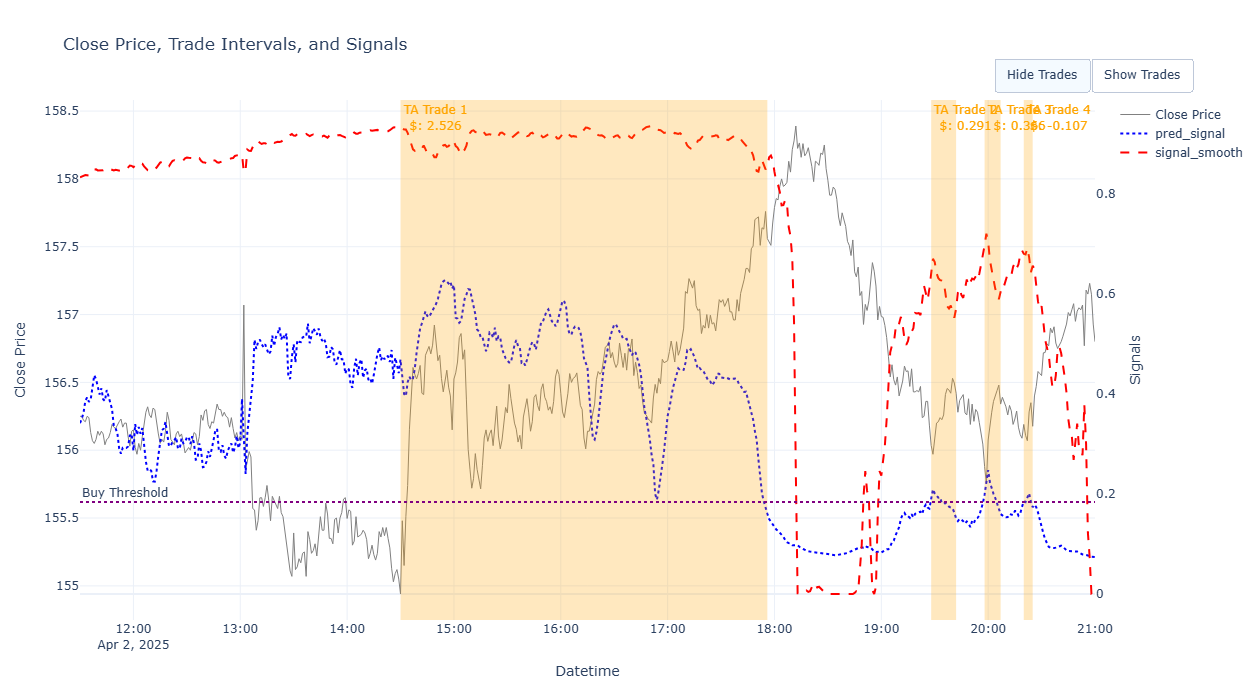


=== Performance for 2025-04-02 00:00:00 ===
Strategy Return ($): 3.076
Buy & Hold Return ($): 1.896
Trades Returns ($): [2.526, 0.291, 0.366, -0.107]


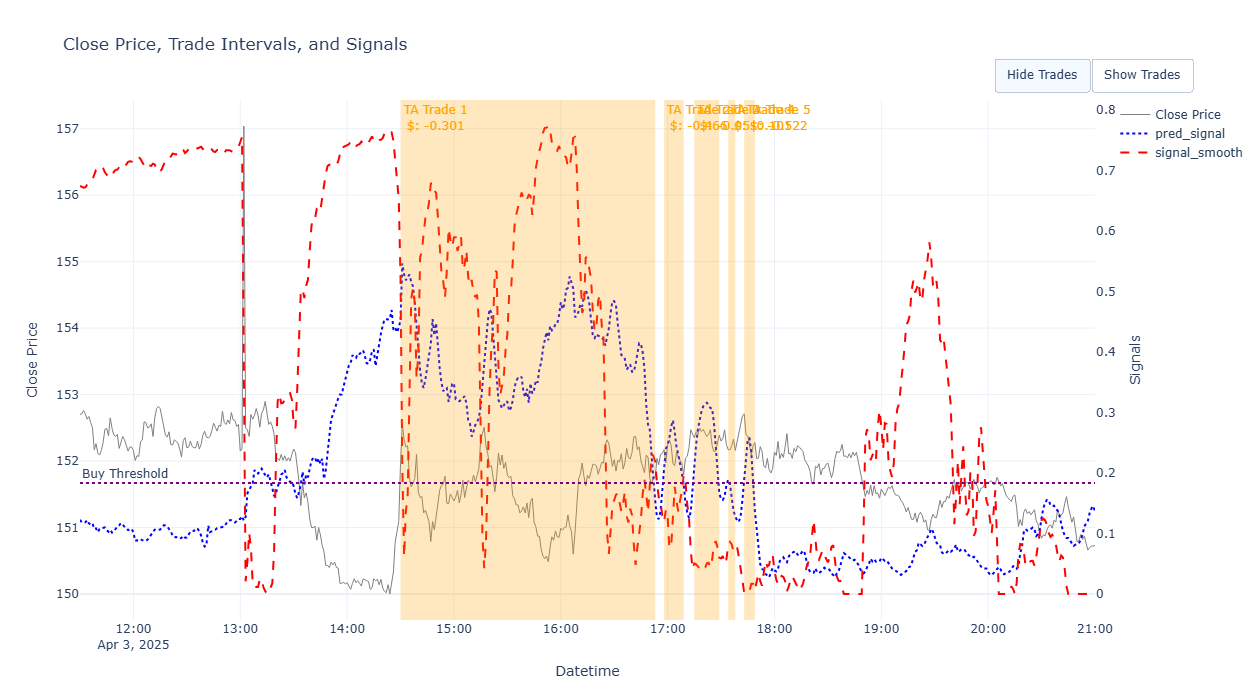


=== Performance for 2025-04-03 00:00:00 ===
Strategy Return ($): -1.441
Buy & Hold Return ($): -1.331
Trades Returns ($): [-0.301, -0.466, -0.051, -0.101, -0.522]


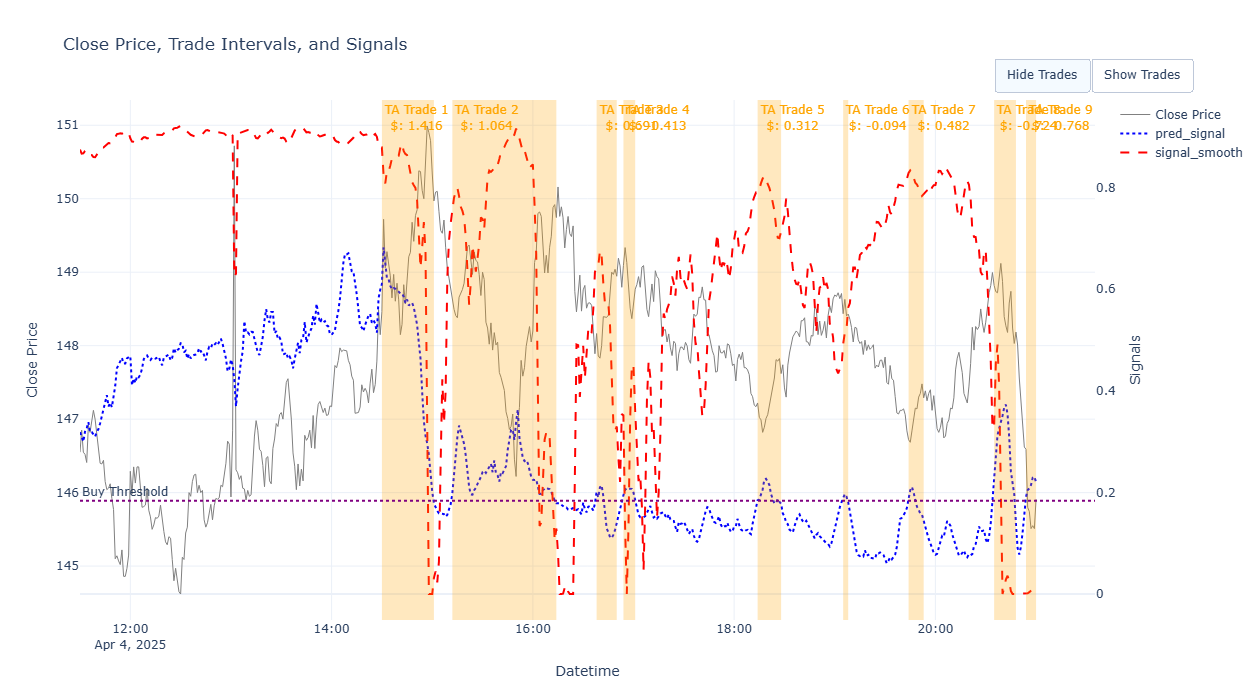


=== Performance for 2025-04-04 00:00:00 ===
Strategy Return ($): 1.565
Buy & Hold Return ($): -3.043
Trades Returns ($): [1.416, 1.064, 0.691, -0.413, 0.312, -0.094, 0.482, -0.724, -0.768]


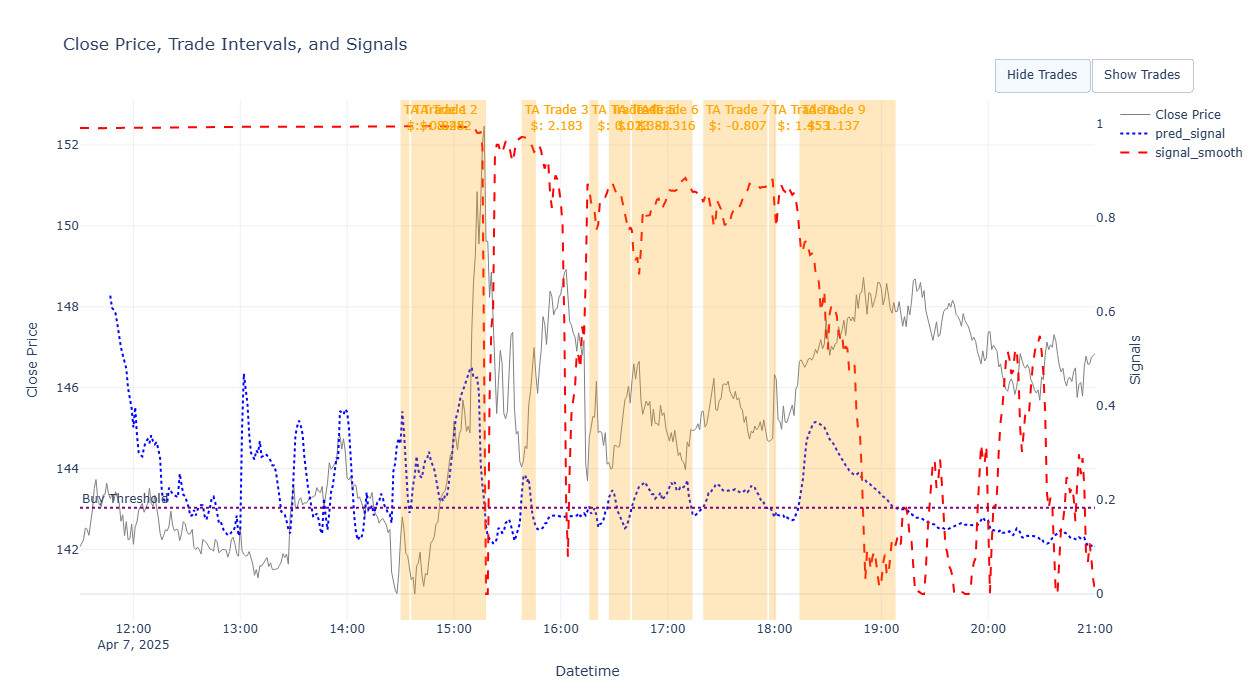


=== Performance for 2025-04-07 00:00:00 ===
Strategy Return ($): 11.492
Buy & Hold Return ($): 4.463
Trades Returns ($): [-0.845, 8.282, 2.183, 0.023, 1.383, -1.316, -0.807, 1.453, 1.137]


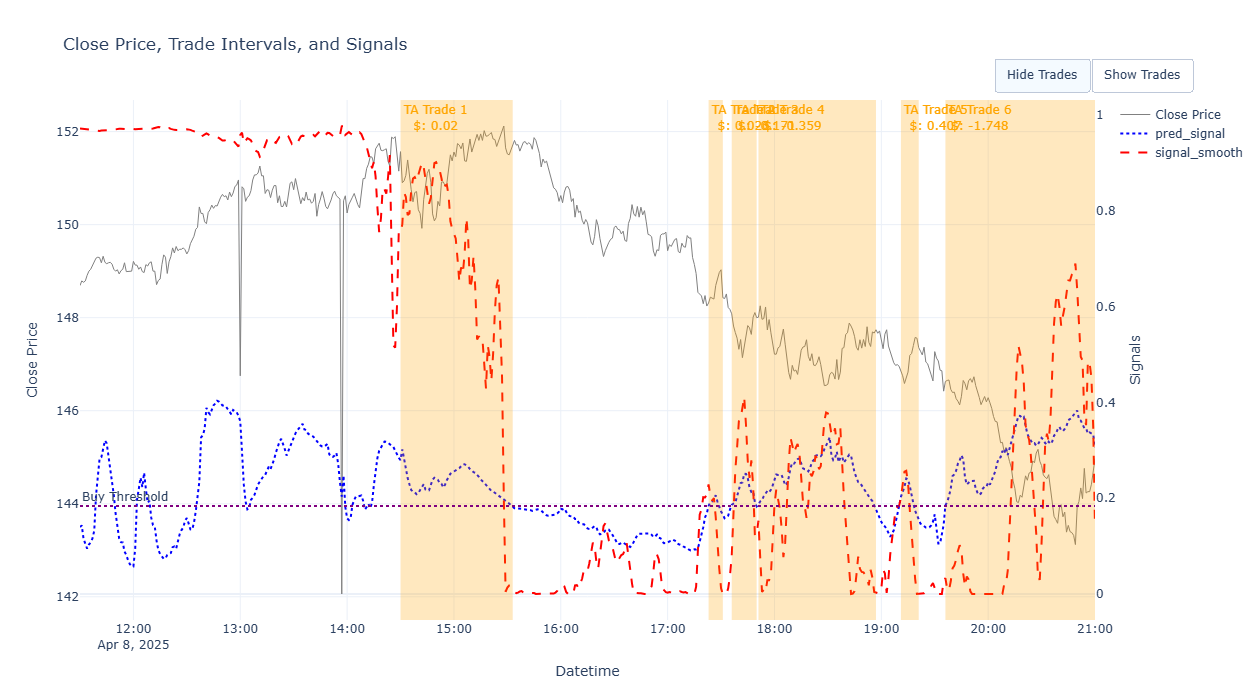


=== Performance for 2025-04-08 00:00:00 ===
Strategy Return ($): -2.114
Buy & Hold Return ($): -6.978
Trades Returns ($): [0.02, 0.026, -0.171, -0.359, 0.407, -1.748]


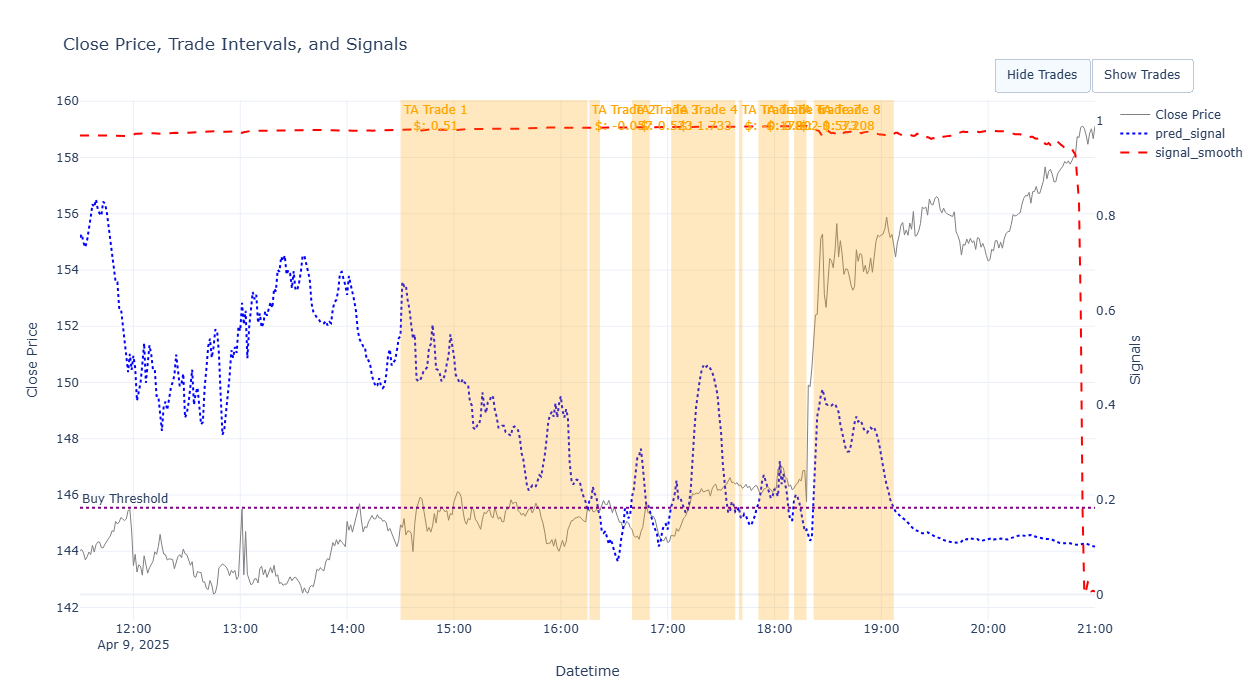


=== Performance for 2025-04-09 00:00:00 ===
Strategy Return ($): 5.168
Buy & Hold Return ($): 13.639
Trades Returns ($): [0.51, -0.057, 0.523, 1.733, -0.178, 0.002, -0.573, 3.208]


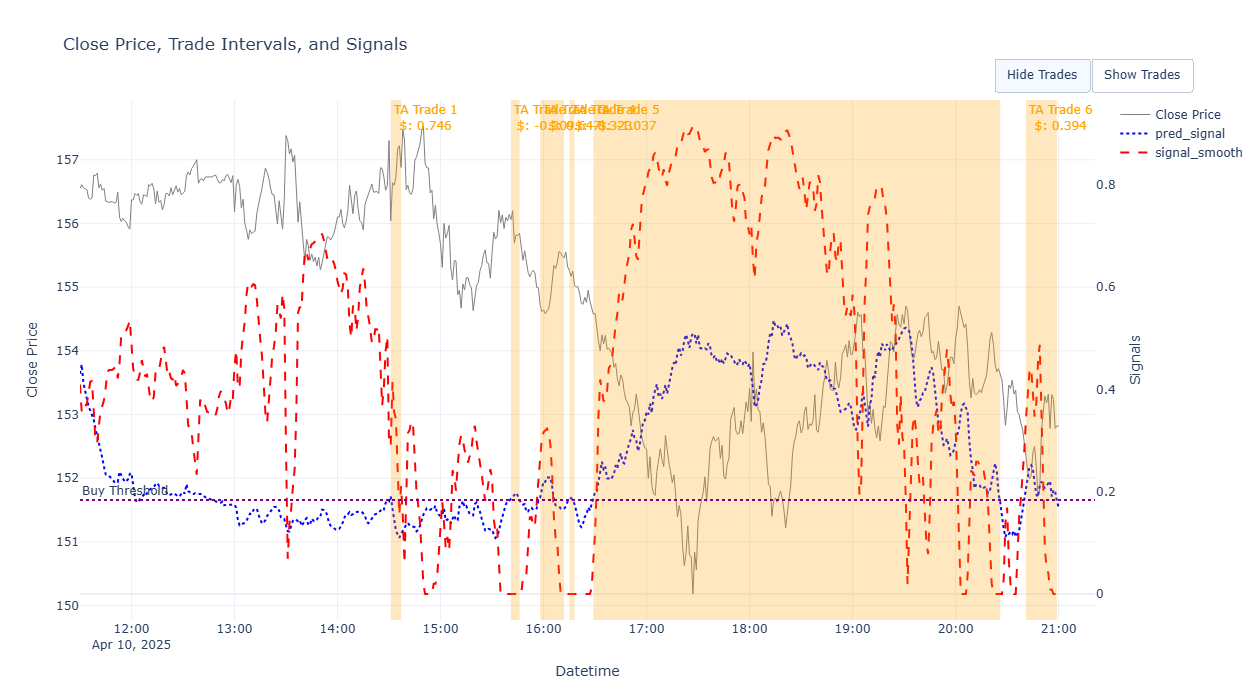


=== Performance for 2025-04-10 00:00:00 ===
Strategy Return ($): 0.117
Buy & Hold Return ($): -4.573
Trades Returns ($): [0.746, -0.309, 0.647, -0.323, -1.037, 0.394]


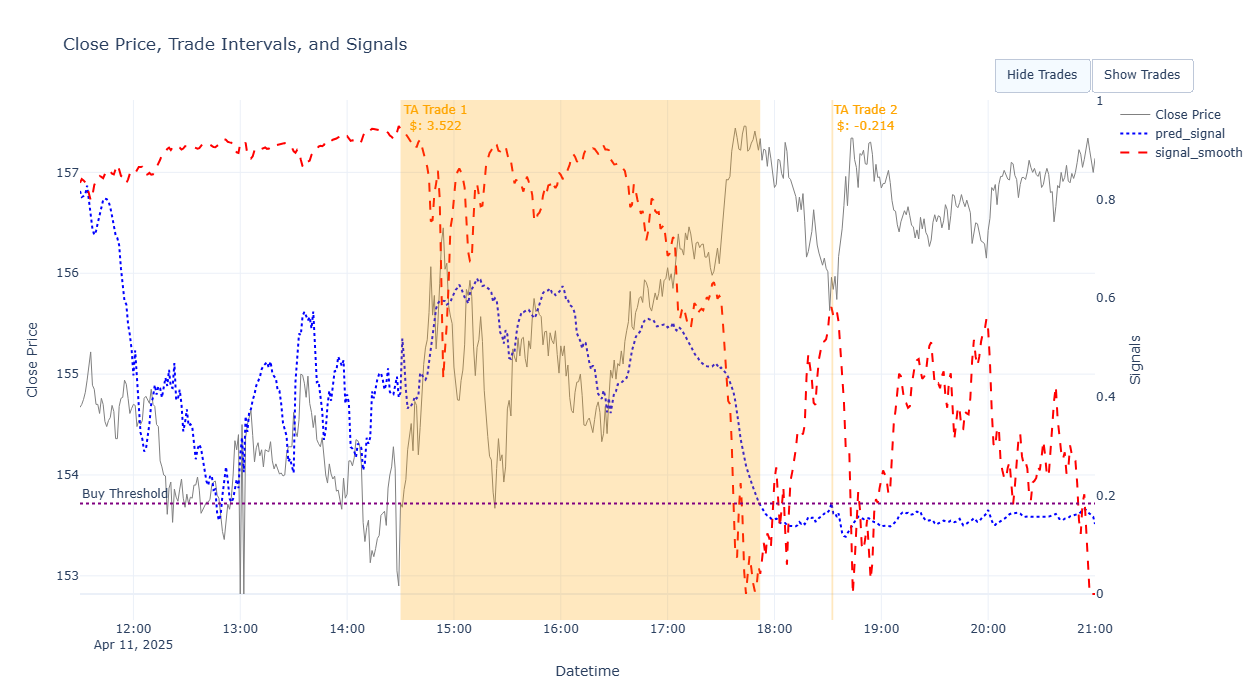


=== Performance for 2025-04-11 00:00:00 ===
Strategy Return ($): 3.308
Buy & Hold Return ($): 3.187
Trades Returns ($): [3.522, -0.214]


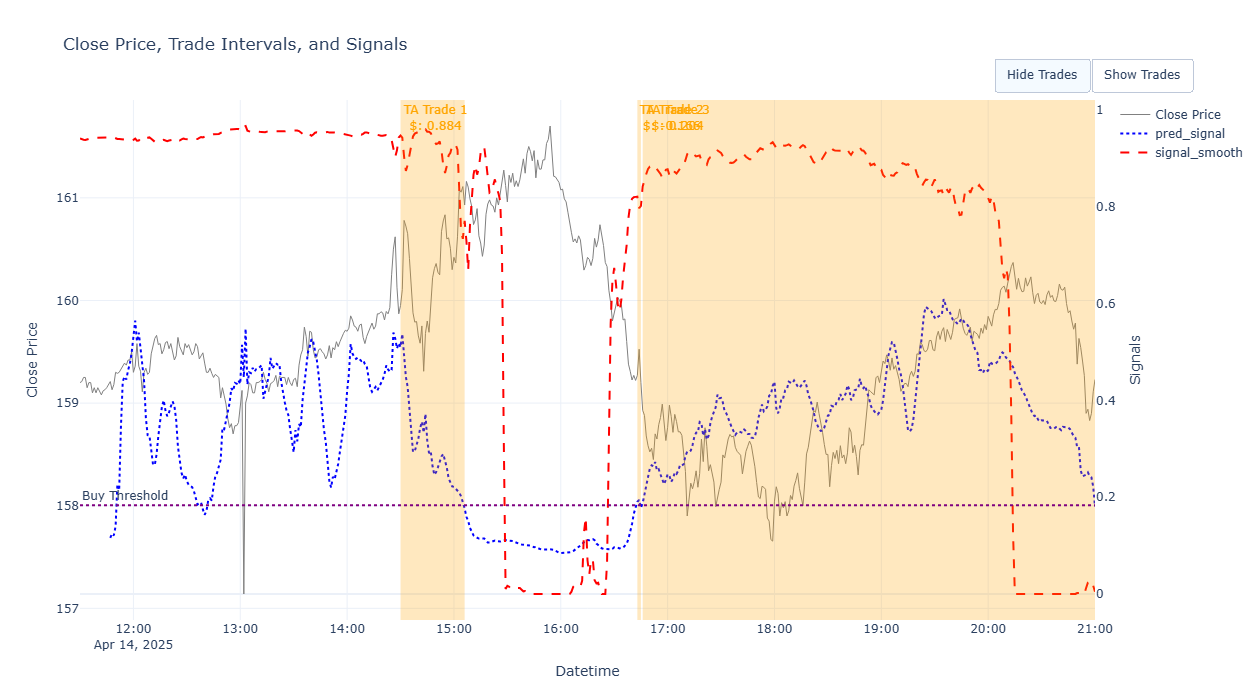


=== Performance for 2025-04-14 00:00:00 ===
Strategy Return ($): 0.803
Buy & Hold Return ($): -0.936
Trades Returns ($): [0.884, -0.166, 0.204]


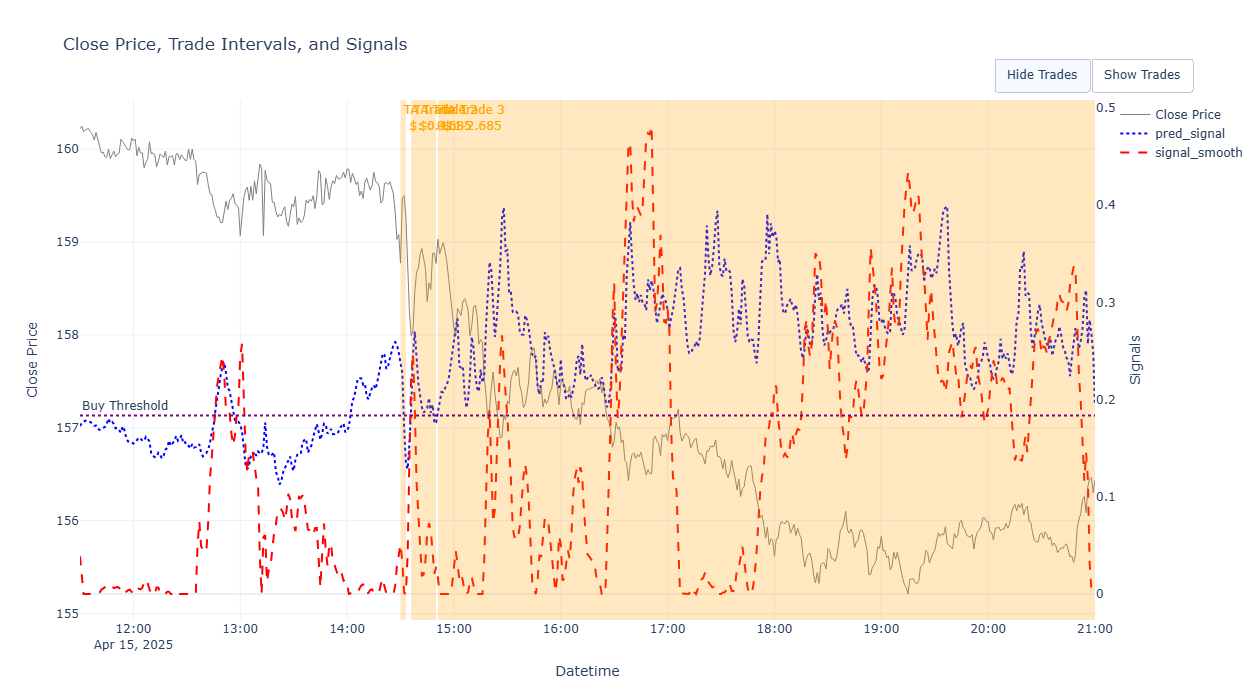


=== Performance for 2025-04-15 00:00:00 ===
Strategy Return ($): -1.728
Buy & Hold Return ($): -2.568
Trades Returns ($): [0.411, 0.685, -2.685]


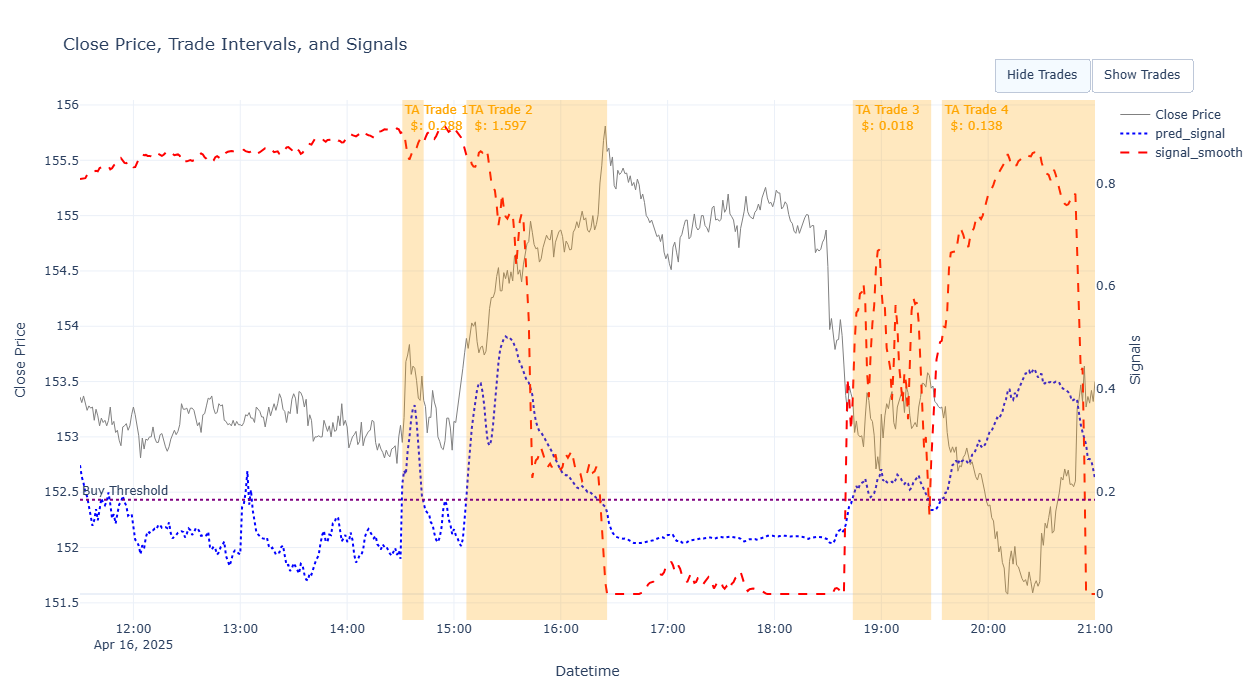


=== Performance for 2025-04-16 00:00:00 ===
Strategy Return ($): 1.861
Buy & Hold Return ($): 0.123
Trades Returns ($): [0.288, 1.597, 0.018, 0.138]


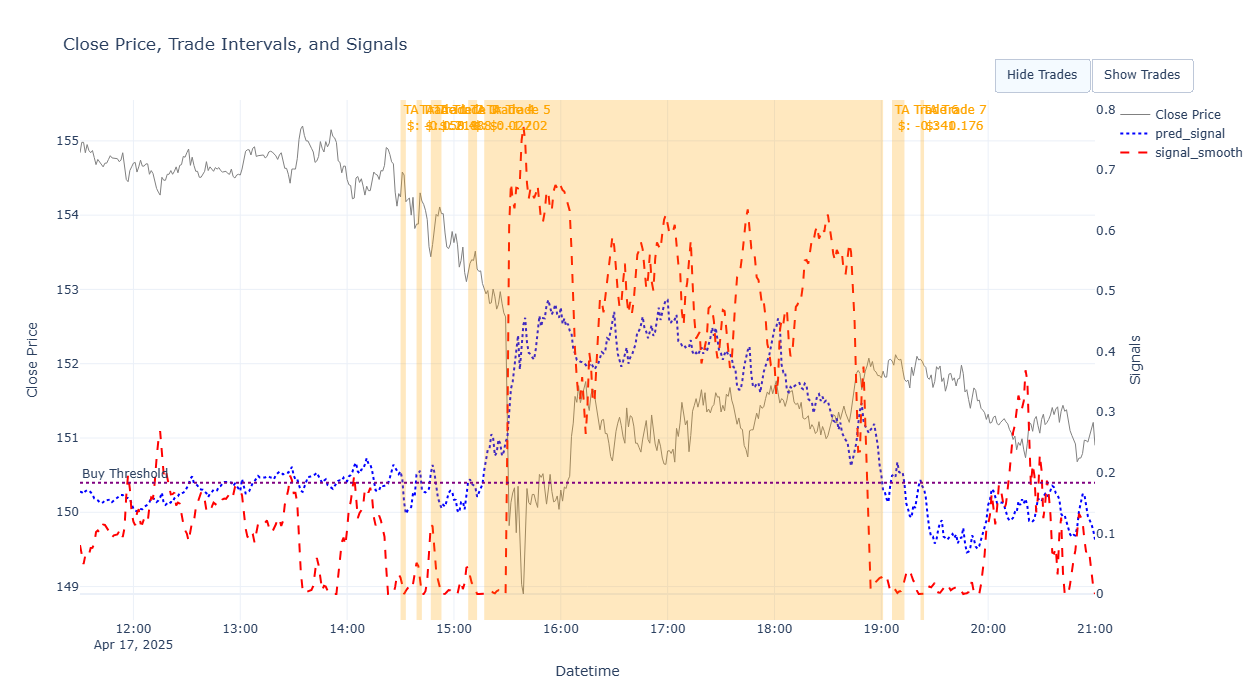


=== Performance for 2025-04-17 00:00:00 ===
Strategy Return ($): -1.198
Buy & Hold Return ($): -3.127
Trades Returns ($): [-0.158, 0.218, 0.488, -0.027, -1.202, -0.341, -0.176]


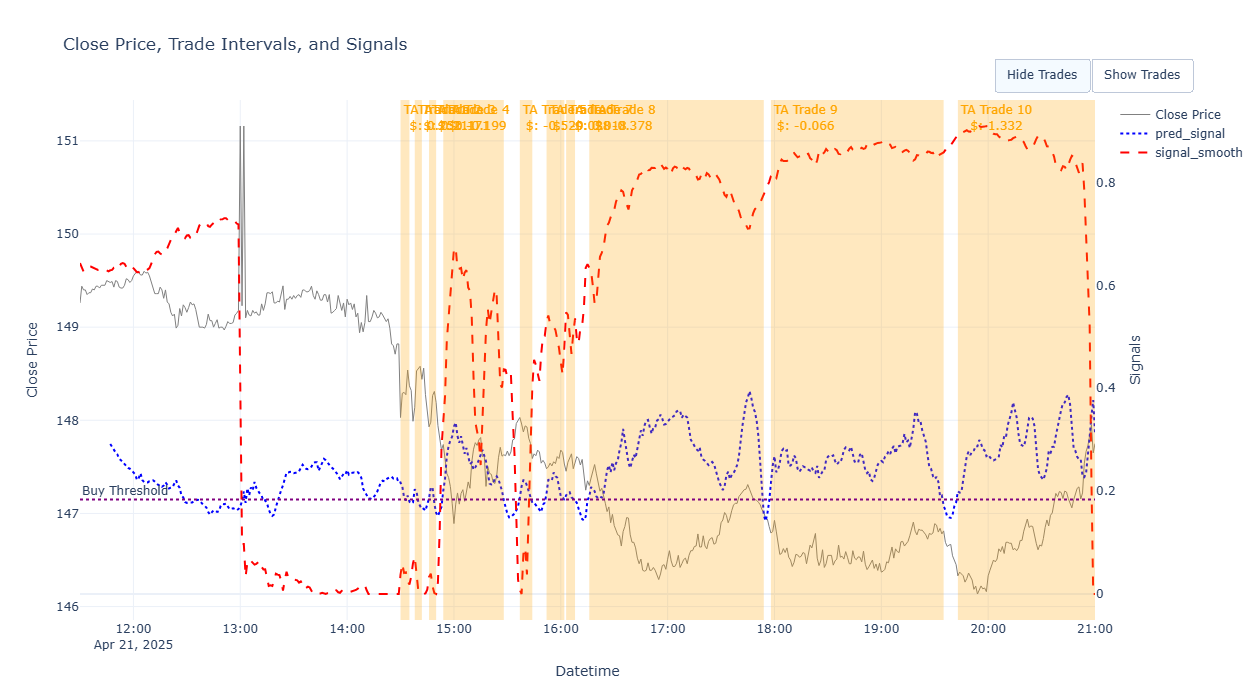


=== Performance for 2025-04-21 00:00:00 ===
Strategy Return ($): 0.674
Buy & Hold Return ($): -0.469
Trades Returns ($): [0.251, 0.211, 0.171, -0.199, -0.529, -0.038, 0.018, -0.378, -0.066, 1.332]


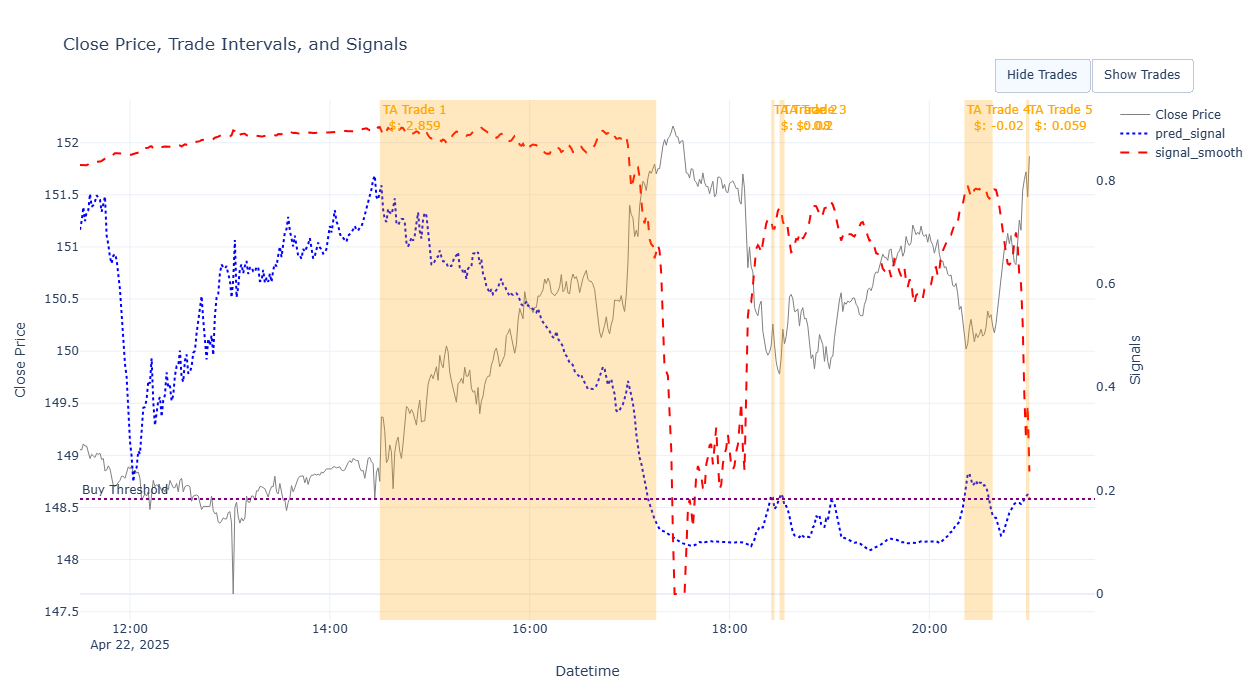


=== Performance for 2025-04-22 00:00:00 ===
Strategy Return ($): 2.628
Buy & Hold Return ($): 2.639
Trades Returns ($): [2.859, -0.08, 0.2, -0.02, 0.059]


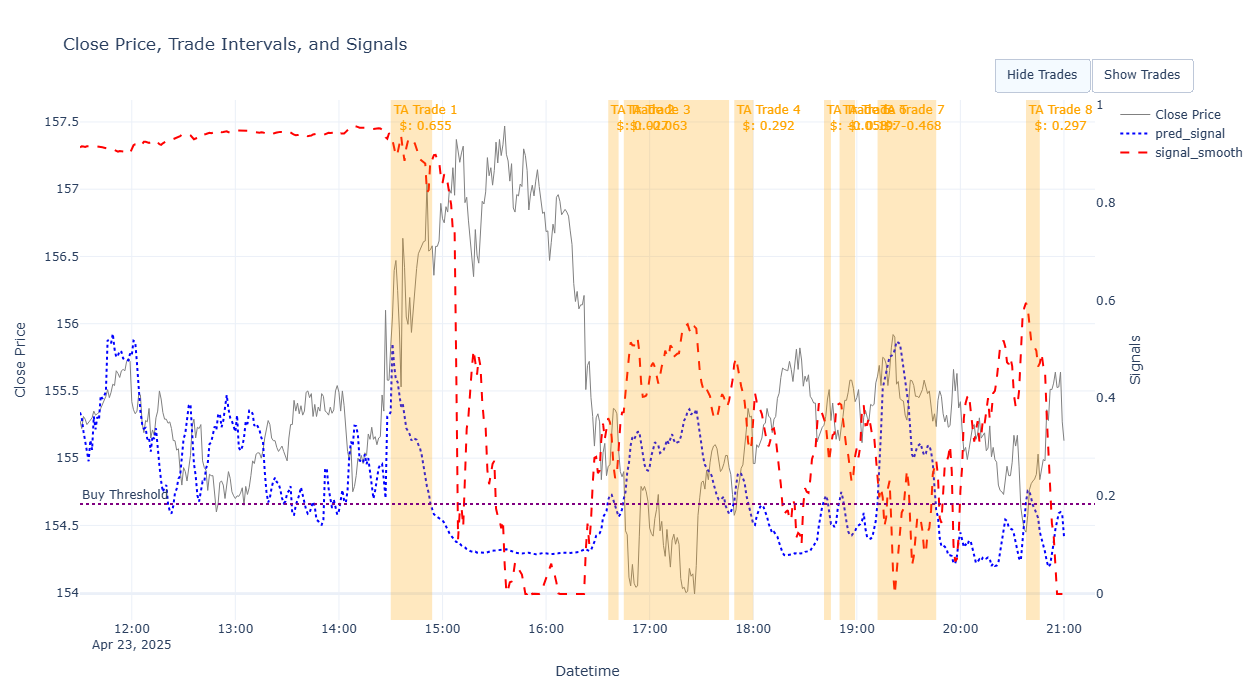


=== Performance for 2025-04-23 00:00:00 ===
Strategy Return ($): 0.879
Buy & Hold Return ($): -0.653
Trades Returns ($): [0.655, 0.027, -0.063, 0.292, -0.058, 0.197, -0.468, 0.297]


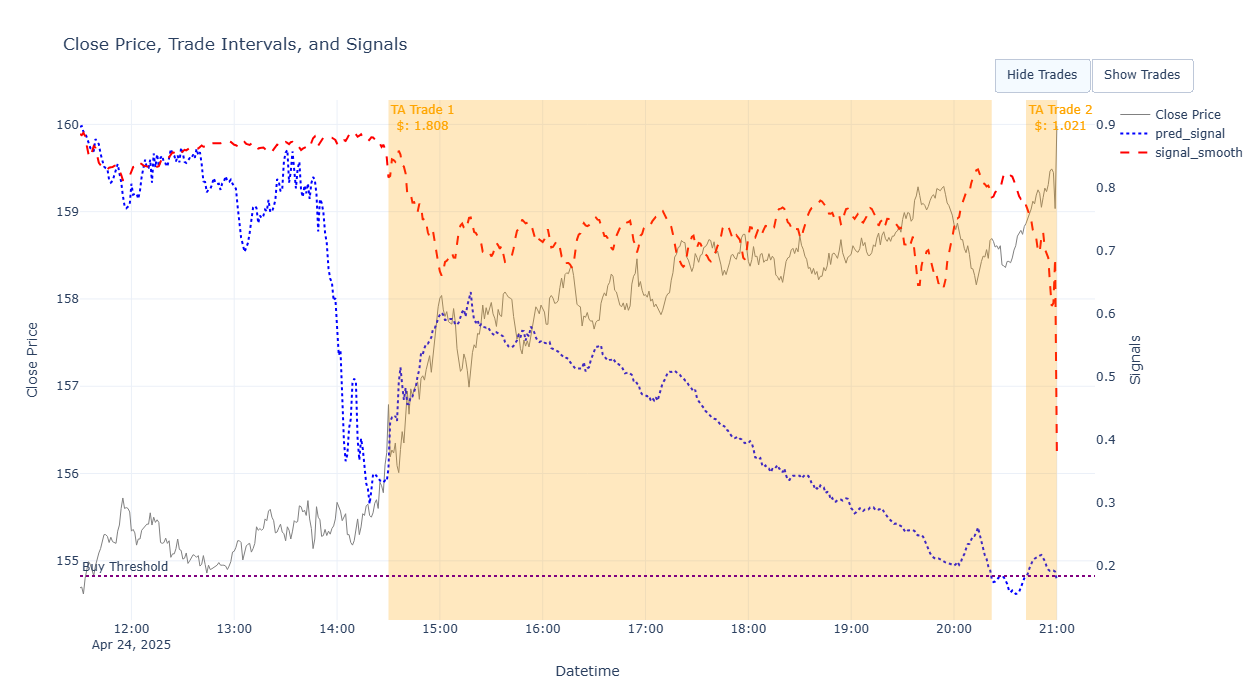


=== Performance for 2025-04-24 00:00:00 ===
Strategy Return ($): 1.883
Buy & Hold Return ($): 2.15
Trades Returns ($): [1.808, 1.021]


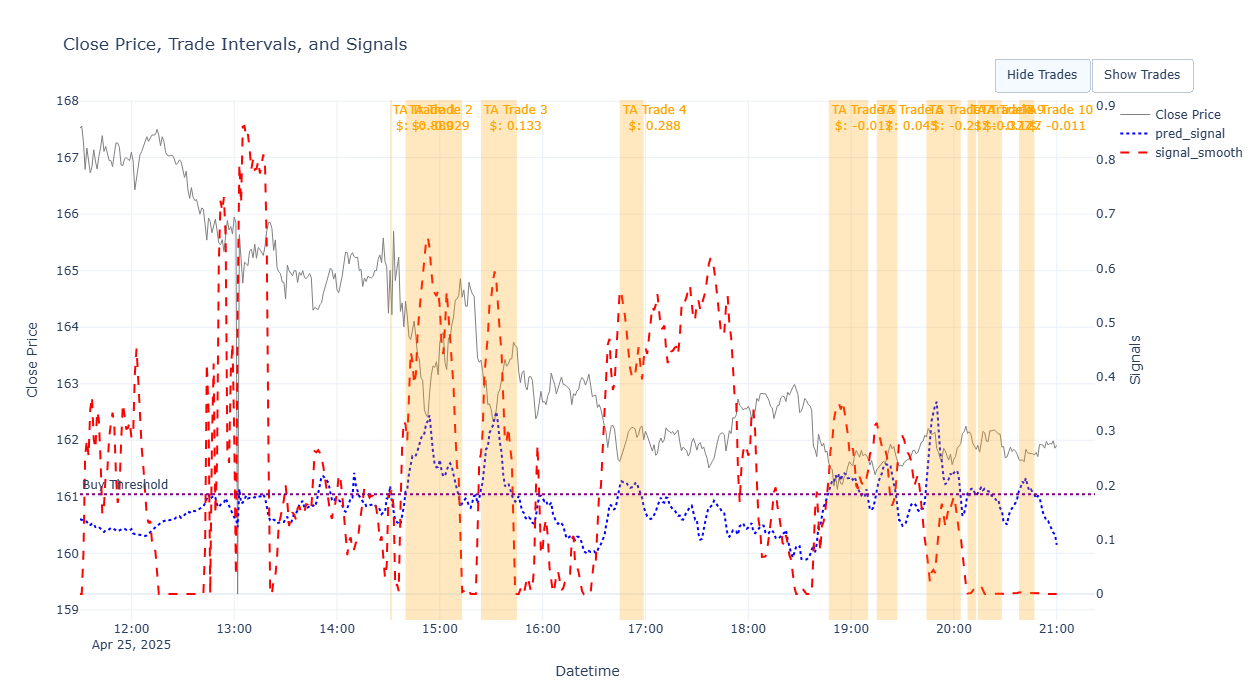


=== Performance for 2025-04-25 00:00:00 ===
Strategy Return ($): -1.196
Buy & Hold Return ($): -2.485
Trades Returns ($): [-0.889, -0.029, 0.133, 0.288, -0.017, 0.045, -0.212, -0.377, -0.127, -0.011]


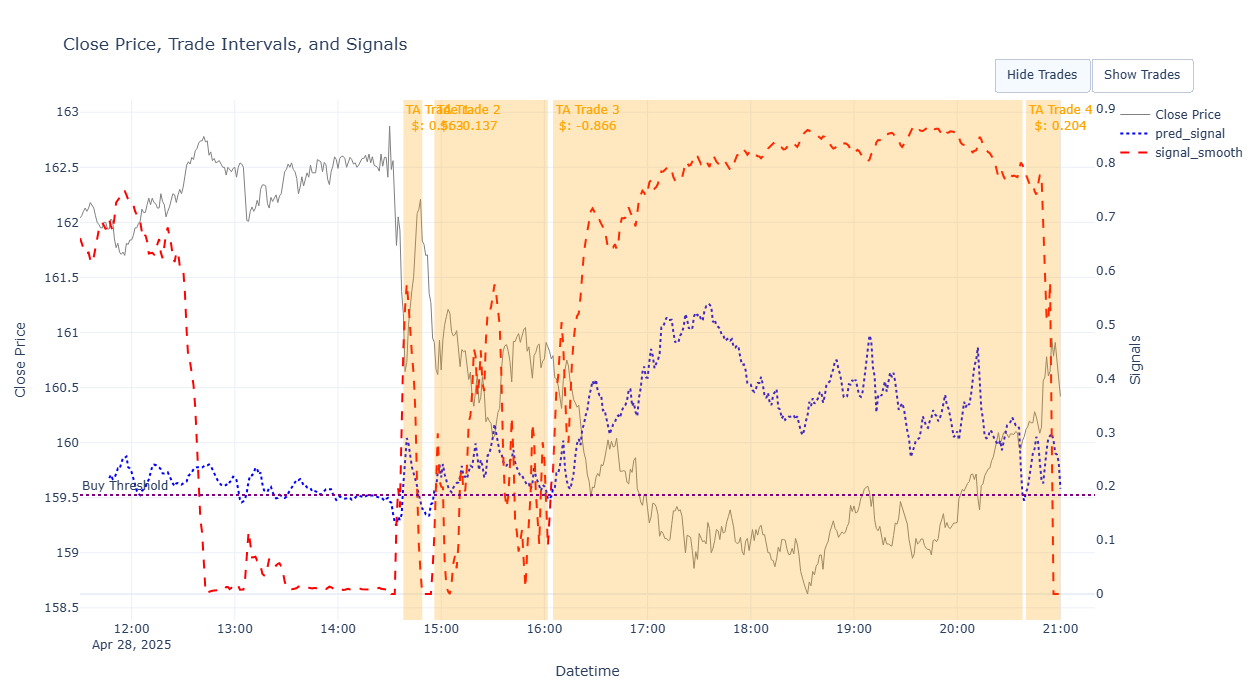


=== Performance for 2025-04-28 00:00:00 ===
Strategy Return ($): -0.046
Buy & Hold Return ($): -2.362
Trades Returns ($): [0.563, -0.137, -0.866, 0.204]


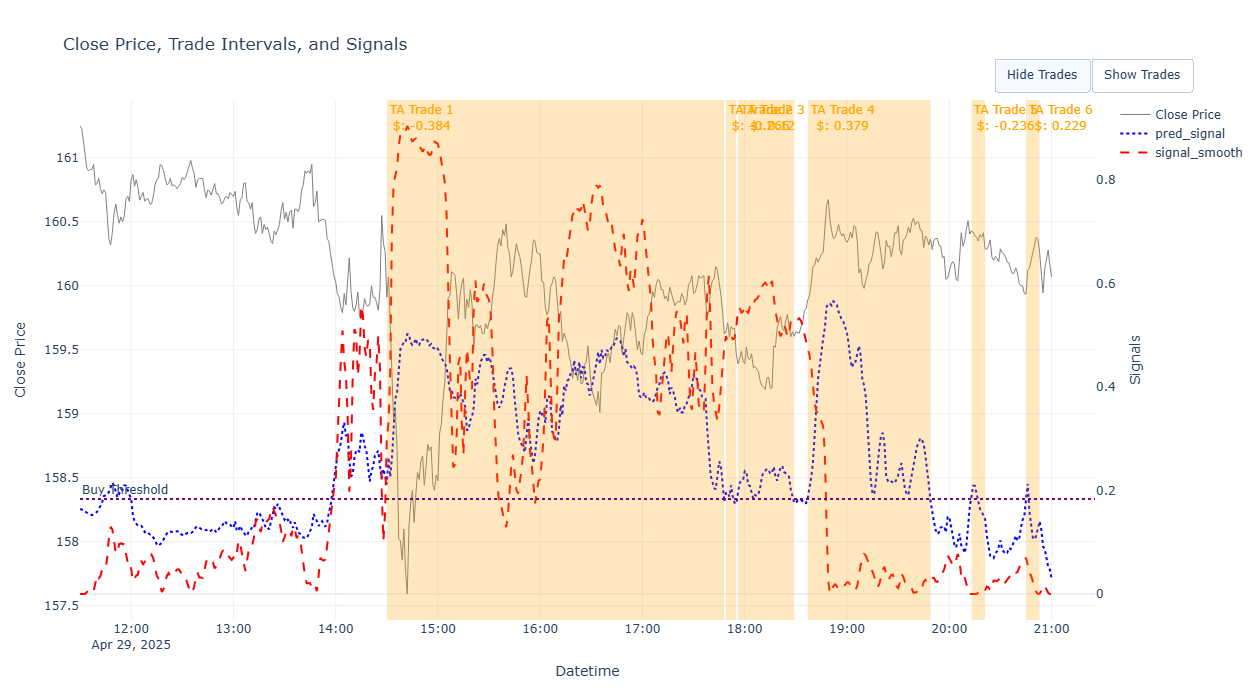


=== Performance for 2025-04-29 00:00:00 ===
Strategy Return ($): -0.158
Buy & Hold Return ($): 0.154
Trades Returns ($): [-0.384, -0.266, 0.12, 0.379, -0.236, 0.229]


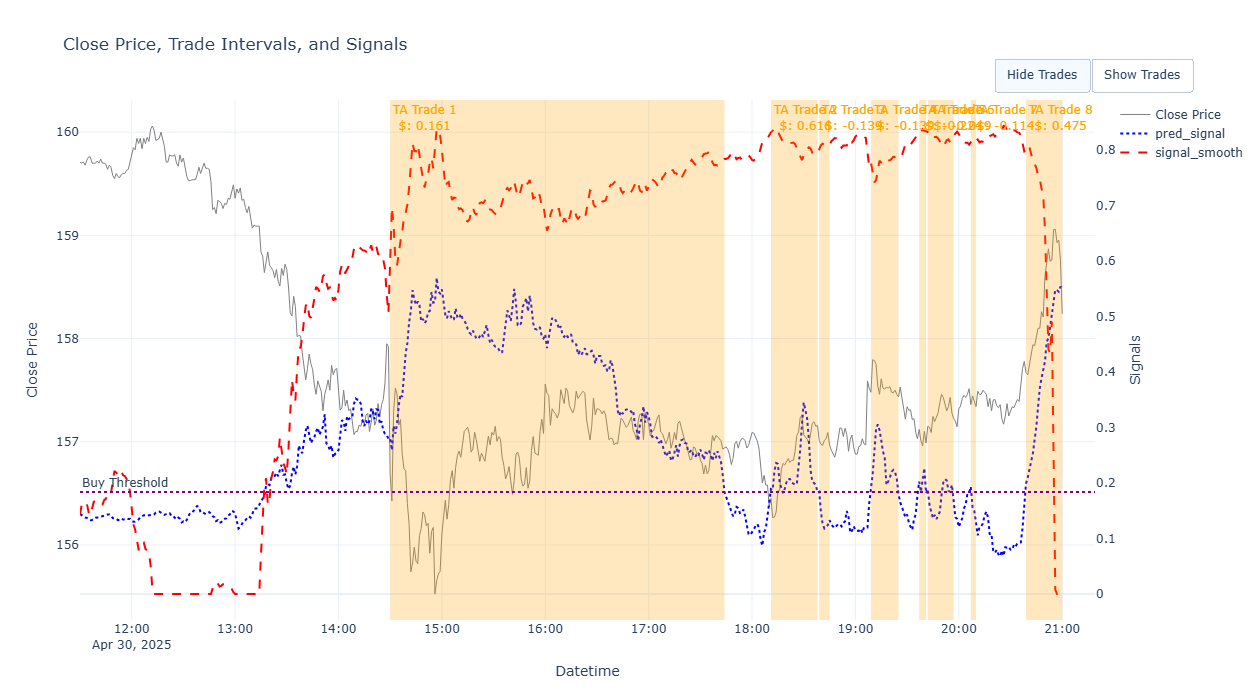


=== Performance for 2025-04-30 00:00:00 ===
Strategy Return ($): 1.136
Buy & Hold Return ($): 1.98
Trades Returns ($): [0.161, 0.616, -0.139, -0.139, -0.224, -0.019, -0.114, 0.475]

=== Overall Summary (2025-04-01 → 2025-04-30) ===
Start date price: 2025-04-01 = 154.0912
  End date price:  2025-04-30 = 158.1925
One-time buy&hold gain: 4.101

{'Buy & Hold – each day ($)': 4.608,
 'Strategy Return ($)': 30.21,
 'Trades Returns ($)': '126 trades'}

=== Overall Summary (2014-04-03 → 2025-06-18) ===
Start date price: 2014-04-03 = 28.5931
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 144.965

{'Buy & Hold – each day ($)': -126.583,
 'Strategy Return ($)': 128.524,
 'Trades Returns ($)': '1977 trades'}


In [13]:
year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
